In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, GRU, concatenate
)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week10/data/UCI HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [6]:
## 데이터 스케일링

# 1. Scaler 객체 생성
scaler = StandardScaler()

# 2. 3D 데이터를 2D로 변환 (samples * timesteps, features)
# (7352, 128, 9) -> (941056, 9)
n_samples_train, n_timesteps, n_features = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features)

# 3. train 데이터로 scaler를 'fit' (통계 계산) 및 'transform' (스케일링)
trainX_scaled_reshaped = scaler.fit_transform(trainX_reshaped)

# 4. 스케일링된 2D 데이터를 다시 3D로 변환
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps, n_features)

# 5. testX도 2D로 변환 (fit 없이 transform만 적용)
n_samples_test = testX.shape[0]
testX_reshaped = testX.reshape(-1, n_features)

# 6. 'fit' 없이 'transform'만 적용 (중요: train 데이터의 통계 사용)
testX_scaled_reshaped = scaler.transform(testX_reshaped)

# 7. testX를 다시 3D로 변환
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps, n_features)

In [7]:
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [9]:
# CNN + GRU 모델 정의

# 입력 레이어
inputs_cnn_gru = Input(shape=(n_timesteps, n_features))

# CNN 부분: 특징 추출
conv_cnn_gru = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs_cnn_gru)
pool_cnn_gru = MaxPooling1D(pool_size=2)(conv_cnn_gru)

# GRU에 연결 (3D 형태 유지)
gru_cnn_gru = GRU(100)(pool_cnn_gru) # GRU 레이어 추가
drop_cnn_gru = Dropout(0.5)(gru_cnn_gru)

# Dense 레이어
dense_cnn_gru = Dense(100, activation='relu')(drop_cnn_gru)
outputs_cnn_gru = Dense(n_outputs, activation='softmax')(dense_cnn_gru)

## MODEL
cnn_gru_model = Model(inputs_cnn_gru, outputs_cnn_gru)

cnn_gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        49,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,298 (243.35 KB)

 Trainable params: 62,298 (243.35 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history_cnn_gru = cnn_gru_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5844 - loss: 1.0652 - val_accuracy: 0.9270 - val_loss: 0.1837
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9377 - loss: 0.1768 - val_accuracy: 0.9423 - val_loss: 0.1574
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9425 - loss: 0.1399 - val_accuracy: 0.9457 - val_loss: 0.1316
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9461 - loss: 0.1334 - val_accuracy: 0.9457 - val_loss: 0.1108
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9565 - loss: 0.1110 - val_accuracy: 0.9474 - val_loss: 0.1080
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9517 - loss: 0.1074 - val_accuracy: 0.9508 - val_loss: 0.1184
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9558 - loss: 0.1122 - val_accuracy: 0.9423 - val_loss: 0.1059
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9458 - loss: 0.1244 - va

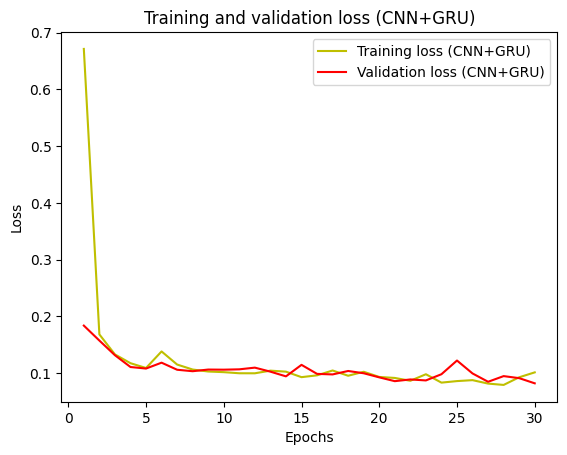

In [11]:
## GRU 모델 학습 결과 시각화

loss_cnn_gru = model_history_cnn_gru.history['loss']
val_loss_cnn_gru = model_history_cnn_gru.history['val_loss']
epochs_cnn_gru = range(1, len(loss_cnn_gru) + 1)
plt.plot(epochs_cnn_gru, loss_cnn_gru, 'y', label='Training loss (CNN+GRU)')
plt.plot(epochs_cnn_gru, val_loss_cnn_gru, 'r', label='Validation loss (CNN+GRU)')
plt.title('Training and validation loss (CNN+GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

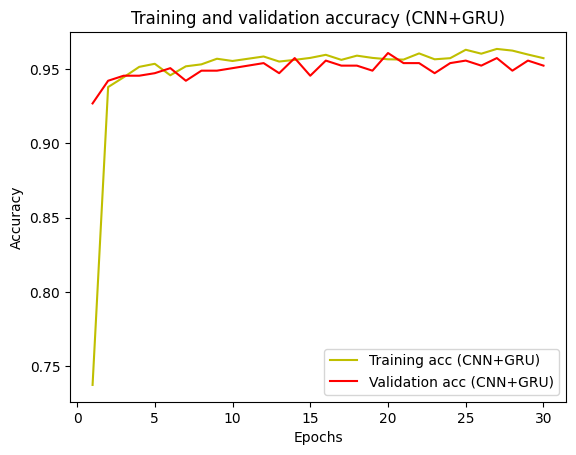

In [12]:
acc_cnn_gru = model_history_cnn_gru.history['accuracy']
val_acc_cnn_gru = model_history_cnn_gru.history['val_accuracy']
plt.plot(epochs_cnn_gru, acc_cnn_gru, 'y', label='Training acc (CNN+GRU)')
plt.plot(epochs_cnn_gru, val_acc_cnn_gru, 'r', label='Validation acc (CNN+GRU)')
plt.title('Training and validation accuracy (CNN+GRU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


--- CNN + GRU Model Evaluation ---
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Confusion Matrix (CNN+GRU):
[[488   1   7   0   0   0]
 [  2 449  19   0   0   1]
 [ 15   5 400   0   0   0]
 [  0   2   0 354 134   1]
 [  0   0   0  31 501   0]
 [  0   0   0   0   0 537]]

Accuracy (CNN+GRU): 0.9260264675941635

Classification Report (CNN+GRU):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.98      0.95      0.97       471
           2       0.94      0.95      0.95       420
           3       0.92      0.72      0.81       491
           4       0.79      0.94      0.86       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



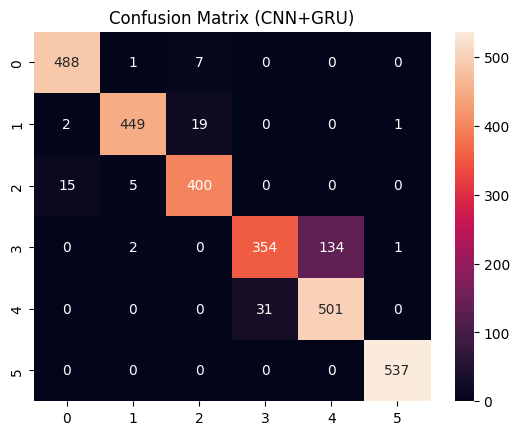

In [13]:
print("\n--- CNN + GRU Model Evaluation ---")
pred_cnn_gru = cnn_gru_model.predict(testX)
pred_cnn_gru_classes = np.argmax(pred_cnn_gru, axis=-1)

cm_cnn_gru = confusion_matrix(testy, pred_cnn_gru_classes)
print("Confusion Matrix (CNN+GRU):")
print(cm_cnn_gru)
print("\nAccuracy (CNN+GRU):", accuracy_score(testy, pred_cnn_gru_classes))
print("\nClassification Report (CNN+GRU):")
print(classification_report(testy, pred_cnn_gru_classes))

sns.heatmap(cm_cnn_gru, annot=True, fmt='d')
plt.title("Confusion Matrix (CNN+GRU)")
plt.show()